In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Information about the test

In this test, the `requests` datasets contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request. The `individuals` datasets contains information about each individual for all requests.
You can use the column `request_id` to link the two datasets.

The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `requests_train`, the predictions should be made for requests listed in the `requests_test` dataset. The competition score should also be computed on the `requests_test`.

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

The score for a random prediction is shown at the end of this notebook (~1.6), your trained models should at least reach a **score below 1** to be significantly better.

Good luck!

## Data description

### File requests_train.csv

| Field name                       | Description                                                                                                                                                        | Type                     |
|----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                      | "the id of request, which is unique in this dataset\."                                                                                                             | string                   |
| animal\_presence                 | flage indicating whether an animal is accompanying the group                                                                                                       | boolean                  |
| answer\_creation\_date           | the timestamp when the anwer was registered                                                                                                                        | timestamp \(iso format\) |
| child\_situation                 | the number representing the situation of the children in the group \(if any\)                                                                                      | integer                  |
| child\_to\_come                  | flag indicating whether the group is expecting a baby                                                                                                              | boolean                  |
| district                         | the id of the administrative district where the request is made\. Each district has its own emergency center responsible for receiving and managing the requests\. | integer                  |
| granted\_number\_of\_nights      | "the target \(train dataset only\), the categorized number of nights granted to the request"                                                                       | integer                  |
| group\_composition\_id           | the number representing the group composition                                                                                                                      | integer                  |
| group\_composition\_label        | the description of the group composition                                                                                                                           | string                   |
| group\_creation\_date            | the timestamp when the group was created in the database                                                                                                           | timestamp \(iso format\) |
| group\_id                        | "the id of the group\. A group can be linked to several requests, so not unique"                                                                                   | string                   |
| group\_main\_requester\_id       | the id of the individual making the request\. it cannot be joined with individual\_id                                                                              | string                   |
| group\_type                      | whether the group is a made of several people \(GROUP\) or just one person \(PERSON\)                                                                              | string                   |
| housing\_situation\_id           | the id of the housing situation of the group when making the request                                                                                               | integer                  |
| housing\_situation\_label        | the description of the housing situation of the group when making the request                                                                                      | string                   |
| long\_term\_housing\_request     | flag indicating whether the groupe has filed a request for a long term housing solution\.                                                                          | boolean                  |
| number\_of\_underage             | the number of individual under 18 in the group                                                                                                                     | integer                  |
| request\_backoffice\_creator\_id | the id of the emergency call center employee who received the request                                                                                              | string                   |
| request\_creation\_date          | the timestamp when the request was made\.                                                                                                                          | timestamp \(iso format\) |
| requester\_type                  | the type of person who called the emergency service \(a user / a social patrol / a third party\)                                                                   | string                   |
| social\_situation\_id            | the id representing the social situation of the group in the database                                                                                              | string                   |
| town                             | the town where the requester is living                                                                                                                             | string                   |
| victim\_of\_violence             | flag indicating whether the group includes an individual victim of violence                                                                                        | boolean                  |
| victim\_of\_violence\_type       | type of the individual victim of violence \(and if it is a case of domestic violence\)                                                                             | string                   |


In [2]:
target ="granted_number_of_nights"

In [ ]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


(238191, 24)

In [94]:
requests_train.shape, requests_test.shape, 

((238191, 24), (59548, 24))

### File individuals_train.csv

| Field name                      | Description                                                                                                               | Type                     |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                     | the id of the request\. It is not unique in this dataset \(a request can be for several individual in case of a group\)\. | string                   |
| individual\_id                  | the id of the individual                                                                                                  | string                   |
| birth\_month                    | month of birth of the individual                                                                                          | integer                  |
| birth\_year                     | the year of birth of the individual                                                                                       | integer                  |
| childcare\_center\_supervision  | flag representing the fact that a child receives follow\-up care                                                          | boolean                  |
| disabled\_worker\_certification | flag representing the fact that an individual is considered disabled regarding the employement law                        | boolean                  |
| gender                          | the gender of the individual                                                                                              | boolean                  |
| housing\_situation\_2\_id       | housing situation category number of the group when making the request \(more precise\)                                   | integer                  |
| housing\_situation\_2\_label    | description of the housing situation of the group when making the request \(more precise\)                                | string                   |
| individual\_creation\_date      | timestamp of the individual creation in the database                                                                      | timestamp \(iso format\) |
| individual\_role                | description of the role of the individual                                                                                 | string                   |
| individual\_role\_2\_id         | category number of the role of the individual                                                                             | integer                  |
| individual\_role\_2\_label      | "description of the role of the individual, more precise than the former"                                                 | string                   |
| marital\_status\_id             | id of the marital status of the individual                                                                                | integer                  |
| marital\_status\_label          | description of the marital status of the individual                                                                       | string                   |
| pregnancy                       | flag representing whether the individual is pregnant \(if applicable\)                                                    | boolean                  |


In [28]:
individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
0,130667d2964de43c511d0ead7ac66b33,b24a8cfaaf3663bac45ca3bcd24f0b36,20,on the street,5,1977,NaN,NaN,male,2018-01-29,isolated person,30,isolated adult,10,single person,f
1,b1cd62fcf24eebb0f685d5eaf55317a8,eef783d1bda82661a751c12c34aff8c2,20,on the street,5,1980,NaN,NaN,male,2019-03-07,NaN,30,isolated adult,-1,NaN,f
2,12cc0a18890bd4959fe42df3ae58838e,927b6fa58d6be263c411332835b11fec,20,on the street,1,2003,NaN,NaN,male,2019-03-13,NaN,10,isolated underage/child,-1,NaN,f
3,ae2d5b4dc181d29e430132f145da1556,94181d5cf4a56cc84d12677df84e2e03,20,on the street,7,1986,NaN,NaN,female,2018-10-09,NaN,30,isolated adult,-1,NaN,f
4,d13a17ce36c832514fda2464e11c4a9f,e79d2e3f9ace50049f1796c098008c13,35,hotel paid by the emergency structure,9,1980,NaN,NaN,female,2017-06-22,husband/spouse,1,partner,-1,NaN,f


In [8]:
individuals_train.shape , individuals_test.shape

((384133, 16), (95641, 16))

## Data-preparation functions

In [114]:

def null_rates(nullmatrix, ascending=False):
    """Returns the rate of null values for each feature from the given null matrix.

    Args:
        nullmatrix (numpy.ndarray): such as computed by null_matrix()

        ascending (:obj:`bool`, optional): Order of sort (False by default for decreasing).
            None to deactivate.


    """
    return (nullmatrix.sum() / nullmatrix.shape[0] * 100).sort_values(
        ascending=ascending)

def null_matrix(df, null_vals=None):
    """Returns the null matrix for the given dataset.

    The null matrix is the dataframe where each value is replaced by True if it is a null
    value (in null_vals) or False otherwise.

    Args:
        df (pandas.DataFrame) : the dataframe to test

        null_vals (:obj:`list`, optional) : the values to interpret as Null values (default None)
            If default then the values are : [None, float('nan'), 'NaT']

    """
    if null_vals is None:
        null_vals = [None, float('nan'), 'NaT']
    return df.isin(null_vals)

def plot_null_rates(df, null_vals):
    """Plots the null rates of the various columns of the dataframe.

    Counts the amount of null values in df, then computes the null rates of
    every columns. Then, displays a stylized pd.DataFrame which highlights the
    null rates of the columns.

    Args:
        df (pd.DataFrame): The dataset whose null rates should be displayed.

        null_vals (list): The values that are considered to be missing values.

    Returns:
        (pd.DataFrame): The stylized dataframe to be displayed.

    Examples:
        >>> null_values = [None, float('nan'), 'NaT']
        >>> df = pd.DataFrame({'A': [1, float('nan')], 'B': [None, 'txt']})
        >>> null_rates_to_display = plot_null_rates(df, null_values)

    """
    null_matrix = df.isin(null_vals)

    df_null_rates = null_rates(null_matrix)

    contains_null = (df_null_rates != 0).values

    missing_values = pd.DataFrame(
        {'contains_null': contains_null, 'null_ratio': df_null_rates}
    ).sort_values('null_ratio', ascending=False)

    def missing_values_styler(null_ratio):
        if null_ratio == 0:
            return 'color: green'
        elif null_ratio < 30:
            return 'color: blue'
        elif null_ratio < 80:
            return 'color: orange'
        else:
            return 'color: red'

    return missing_values.style.applymap(
        missing_values_styler,
        subset=['null_ratio']
    )


def missing_value_rate(df, null_vals):
    """Returns the global missing value rate in the dataframe df.

    Uses the null_values parameter to count the number of missing values per
    column in the dataset. Then, computes the global missing value rate.

    Args:
        df (pandas.DataFrame): The dataset to compute the missing value rate on.

        null_vals (list): The values that are considered to be missing values.

    Returns:
        float: The global missing value rate.

    Examples:
        >>> null_values = [None, float('nan'), 'NaT']
        >>> df = pd.DataFrame({'A': [1, float('nan')], 'B': [None, 'txt']})
        >>> missing_value_rate(df, null_vals)
        0.5

    """
    null_matrix = df.isin(null_vals)
    return null_matrix.sum().sum() / (null_matrix.shape[0] *
                                      null_matrix.shape[1])

In [115]:
def plot_correlation_matrix(corrmatrix, figsize=None):
    """Plot a correlation matrix heat map.

    Uses the provided correlation matrix to plot a seaborn heatmap. Wrapper of
    seaborn.heatmap.

    Args:
        corrmatrix (pandas.DataFrame): The correlation matrix as a DataFrame
            such as index and column are a same list, containing features.
            Each cell contains the correlation of (feature1, feature2). Such a
            matrix can be obtained by calling DataFrame.corr()

        figsize (tuple of ints): The figsize argument to be passed to
            seaborn.heatmap.

    Examples:
        >>> df = pd.DataFrame({'A': [1, 2, 3, 4, 5], 'B': [3, 4, 4, 6, 6]})
        >>> plot_correlation_matrix(df.corr())

    References:
        https://seaborn.pydata.org/generated/seaborn.heatmap.html

    """
    if figsize is not None:
        plt.figure(figsize=figsize)
    sns.heatmap(
        corrmatrix, vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200), square=True,
        robust=True
    )

In [116]:
def remove_duplicates(df, keep='first'):
    """Removes the duplicated rows from the dataframe.

    Returns a new dataset stripped from duplicated rows (keep the first one).
    Wrapper of the pandas.DataFrame.duplicated method.

    Parameters:
        df (pandas.DataFrame): The dataset to clear from duplicated rows.

        keep (:obj:`str`, optional): In {'first', 'last', False}. 'first' by default.
           The duplicated value to keep. If False, all values are dropped.

    Returns:
        (pandas.DataFrame) The dataframe without duplicated rows.

    References:
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html

    Examples:
        >>> df = pd.DataFrame({'my_feature': ['A', 'A', 'A', 'B', 'C', 'C']})
        >>> remove_duplicates(df)
          my_feature
        0          A
        3          B
        4          C
    """
    return df[np.logical_not(df.duplicated(keep=keep))]

In [117]:
def series_is_categorical(series):
    """Indicates if the series contains data of dtype Categorical

    Args:
        series (pd.Series) : the series to check

    Returns:
        True if the series has dtype categorical, False otherwise
    """
    return isinstance(series.dtype, pd.CategoricalDtype)
def add_new_category(df, cat_features, category_name, inplace=False):
    """Add the new category 'category_name' to the features in cat_features.

    In pandas, columns that are of type category can't be assigned a new category/value
    without declaring it first (See references).

    Args:
       df (pandas.DataFrame) : The dataset

       cat_features (Union[str, list]) : The list of category features. The dtypes need to be "category".

       category_name (object) : The new category to add

    Returns:

    References:
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.add_categories.html

    """
    if isinstance(cat_features, str):
        cat_features = [cat_features]

    if inplace:
        for c in cat_features:
            df[c].cat.add_categories(new_categories=category_name, inplace=True)
    else:
        df_res = df.copy()
        for c in cat_features:
            df_res[c].cat.add_categories(new_categories=category_name, inplace=True)
        return df_res
    
def columns_by_type(df):
    """
    Returns 3 lists of columns, the first being the numerical columns,
    the second are the categorical columns, and the last are the dates.
    Dates must be of type np.datetime64. Dates represented as string won't be
    detected.

    Parameters
    ----------
    df : {pandas.DataFrame} the data

    Returns
    -------
    out : {Tuple} (numerical, categorical, dates) the column lists
    """

    dates = df.select_dtypes(include=[np.datetime64]).columns
    categorical = df.select_dtypes(include=['O', "category", "bool"]).columns
    numerical = df.columns.drop(dates).drop(categorical)

    return numerical, categorical, dates

def fill_na(df, numerical_filling=-1, categorical_filling='None',
            date_filling=pd.to_datetime('today'), filling_dict=None):
    """Fills the null values of the data frame with the given values.

    Fills the values considered as null such as numpy.NaN and None. The filling
    value depends on the feature of the null value. The filling value provided
    in filling_dict is used, and, if no filling value is found, the generic
    filling values are used depending on the feature type.
    This method is a wrapper of pandas.DataFrame.fillna.

    Args:
        df (pandas.DataFrame) the dataset whose missing value should be filled.

        numerical_filling (float): Defaults to -1.
            Filling value for numerical columns not specified in filling_dict.

        categorical_filling (object): Defaults to 'None'.
            Filling value for categorical columns not specified in filling_dict.

        date_filling (pd.datetime64): Defaults to pd.to_datetime('today').
            Filling value for date columns not specified in filling_dict.

        filling_dict : (dict) Defaults to None.
            Filling values for specific features. To assign a specific fill
            value for feature 'f', provide filling_dict={'f': 'value'}
            This dictionary takes priority over the type-specific filling
            values arugments.

    Returns:
        (pandas.DataFrame) The dataframe with missing values updated as
        specified.

    References:
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html

    Examples:
        >>> from data_preparation.cleaning import fill_na
        >>> df = pd.DataFrame({'A' : pd.to_datetime(['1966-05-12', pd.NaT, \
'2010-07-06', '2020-01-01']), 'B' : [1.2, 5.6, np.NaN, 100], \
'C' : [None, 'hello', 'world', '!']})
        >>> fill_na(df, filling_dict={'A' : pd.to_datetime('1960-01-01')})
                   A      B      C
        0 1966-05-12    1.2   None
        1 1960-01-01    5.6  hello
        2 2010-07-06   -1.0  world
        3 2020-01-01  100.0      !
    """

    df = df.copy()
    if filling_dict is None:
        filling_dict = {}

    num_col, cat_col, dates_col = columns_by_type(df)

    # for category dtypes, explicitly add the new category beforehand
    for c in cat_col:
        if series_is_categorical(df[c]):
            new_cat = filling_dict[c] if c in filling_dict else categorical_filling
            add_new_category(df=df, cat_features=c, category_name=new_cat, inplace=True)

    for col_type, col_default_fill in zip([num_col, cat_col, dates_col],
                                          [numerical_filling,
                                           categorical_filling, date_filling]):
        for c in col_type:
            if c not in filling_dict:
                filling_dict[c] = col_default_fill

    df.fillna(filling_dict, inplace=True)
    return df


## Data analysis (agregation and merging)

In [101]:
# Vérifier la présence de toutes les requetes dans le jeu de données des individus 
assert requests_train['request_id'].isin(individuals_train['request_id']).all(), "Certaines request_id de requests_train ne sont pas présentes dans individuals_train"
assert requests_test['request_id'].isin(individuals_test['request_id']).all(), "Certaines request_id de requests_train ne sont pas présentes dans individuals_train"

#### Convert bool columns 

In [102]:
## convert gender column of individual_train
individuals_train["gender"] = individuals_train["gender"].astype(str).str.lower().map({"male": 1, "female": 0})
individuals_train["gender"] = individuals_train["gender"].fillna(-1).astype(int)
individuals_train["gender"].value_counts()

-1    384133
Name: gender, dtype: int64

In [103]:
## convert gender column of individual_train
individuals_test["gender"] = individuals_test["gender"].astype(str).str.lower().map({"male": 1, "female": 0})
individuals_test["gender"] = individuals_test["gender"].fillna(-1).astype(int)
individuals_test["gender"].value_counts()

-1    95641
Name: gender, dtype: int64

In [104]:
## convert pregnancy column
individuals_train["pregnancy"] = individuals_train["pregnancy"].astype(str).str.lower().map({"t": 1, "f": 0})
individuals_train["pregnancy"] = individuals_train["pregnancy"].fillna(-1).astype(int)
individuals_train["pregnancy"].value_counts()

-1    384133
Name: pregnancy, dtype: int64

In [105]:
## convert pregnancy column
individuals_test["pregnancy"] = individuals_test["pregnancy"].astype(str).str.lower().map({"t": 1, "f": 0})
individuals_test["pregnancy"] = individuals_test["pregnancy"].fillna(-1).astype(int)
individuals_test["pregnancy"].value_counts()

-1    95641
Name: pregnancy, dtype: int64

In [106]:
#create age column
from datetime import datetime
individuals_train["age"] = datetime.now().year - individuals_train["birth_year"]
individuals_test["age"] = datetime.now().year - individuals_test["birth_year"]

#### agregate int interesting columns in individual dataset

In [107]:
# aggregate columns
agg_dict= {
    'age': ['mean', 'min', 'max'],
    'gender' : 'sum',
    'pregnancy': 'sum',
    'housing_situation_2_id':'mean',
    'individual_id': 'count'

}
individuals_train_agg = individuals_train.groupby('request_id').agg(agg_dict)
individuals_test_agg = individuals_train.groupby('request_id').agg(agg_dict)

In [108]:
individuals_train_agg.columns = ['_'.join(col).strip() for col in individuals_train_agg.columns.values]
individuals_train_agg.reset_index(inplace=True)
individuals_train_agg

,request_id,age_mean,age_min,age_max,gender_sum,pregnancy_sum,housing_situation_2_id_mean,individual_id_count
0,0000602749161524aedd04269957e5fc,29.0,29,29,-1,-1,20,1
1,0000c66f6bb24e930cba6a3872d3ab02,44.0,44,44,-1,-1,20,1
2,0000dbd253c096eab97cab0545915ab2,25.0,25,25,-1,-1,20,1
3,0001826bdd626262ec2bda3a1b908aac,45.0,45,45,-1,-1,20,1
4,0001925b4cd4d65110638ee3d5f2f454,32.0,32,32,-1,-1,20,1
...,...,...,...,...,...,...,...,...
238186,fffd7c7c22a9147bc4af4b869eb97f19,39.0,39,39,-1,-1,20,1
238187,fffeeac2155c826f0ccc2f912c1049f9,48.0,48,48,-1,-1,20,1
238188,fffeff160a0bf8c160c9e63436273cec,37.0,37,37,-1,-1,32,1
238189,ffff40d1408c4f032e1047adab9fbf93,43.0,43,43,-1,-1,47,1


In [109]:
individuals_test_agg.columns = ['_'.join(col).strip() for col in individuals_test_agg.columns.values]
individuals_test_agg.reset_index(inplace=True)
individuals_test_agg

,request_id,age_mean,age_min,age_max,gender_sum,pregnancy_sum,housing_situation_2_id_mean,individual_id_count
0,0000602749161524aedd04269957e5fc,29.0,29,29,-1,-1,20,1
1,0000c66f6bb24e930cba6a3872d3ab02,44.0,44,44,-1,-1,20,1
2,0000dbd253c096eab97cab0545915ab2,25.0,25,25,-1,-1,20,1
3,0001826bdd626262ec2bda3a1b908aac,45.0,45,45,-1,-1,20,1
4,0001925b4cd4d65110638ee3d5f2f454,32.0,32,32,-1,-1,20,1
...,...,...,...,...,...,...,...,...
238186,fffd7c7c22a9147bc4af4b869eb97f19,39.0,39,39,-1,-1,20,1
238187,fffeeac2155c826f0ccc2f912c1049f9,48.0,48,48,-1,-1,20,1
238188,fffeff160a0bf8c160c9e63436273cec,37.0,37,37,-1,-1,32,1
238189,ffff40d1408c4f032e1047adab9fbf93,43.0,43,43,-1,-1,47,1


In [110]:
cat__individual_cols = [
    'housing_situation_2_label',
    'individual_role',
    'individual_role_2_label',
    'marital_status_label'
]


In [111]:
def get_mode(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else None


In [ ]:
## Extract and merge cat individuals columns to request_
cat__individual_train_cols = pd.DataFrame({'request_id': individuals_train['request_id'].unique()})
cat__individual_test_cols= pd.DataFrame({'request_id': individuals_test['request_id'].unique()})

## Extract and merge cat_individuals_train_cols by grouping with request_id
for col in cat__individual_cols:
    col_mode = individuals_train.groupby('request_id')[col].agg(get_mode).reset_index()
    col_mode.rename(columns={col: f'{col}_mode'}, inplace=True)
    cat__individual_train_cols = cat__individual_train_cols.merge(col_mode, on='request_id', how='left')
## Extract and merge cat_individuals_test_cols by grouping with request_id
for col in cat__individual_cols:
    col_mode = individuals_test.groupby('request_id')[col].agg(get_mode).reset_index()
    col_mode.rename(columns={col: f'{col}_mode'}, inplace=True)
    cat__individual_test_cols = cat__individual_test_cols.merge(col_mode, on='request_id', how='left')



#### Merge 

In [ ]:
## df train
df_train = requests_train.merge(cat__individual_train_cols, on="request_id", how='left')
df_train = df_train.merge(individuals_train_agg, on="request_id", how='left')


In [ ]:
## df_test
df_test = requests_test.merge(cat__individual_test_cols, on="request_id", how='left')
df_test = df_test.merge(individuals_test_agg, on="request_id", how='left')

In [ ]:
print(f"Shape of df_train is :{df_train.shape}")
print(f"Shape of df_test is :{df_test.shape}")


Shape of df_train is :(238191, 35)
Shape of df_test is :(59548, 35)


In [ ]:
assert df_train.shape[0] == requests_train.shape[0], "Shape has changed!"
assert df_test.shape[0] == requests_test.shape[0], "Shape has changed!"

In [ ]:
df_train.describe()

,child_situation,district,granted_number_of_nights,group_composition_id,housing_situation_id,number_of_underage,age_mean,age_min,age_max,gender_sum,pregnancy_sum,housing_situation_2_id_mean,individual_id_count
count,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000
mean,-0.322304,7078.893573,0.689199,27.939679,121.939872,-0.575530,40.147342,36.575442,44.116696,0.978815,0.046916,23.162172,1.612710
std,4.086288,46551.615070,0.769985,28.893907,83.223893,0.860536,31.317484,33.125030,30.992719,0.711021,0.211916,7.028155,1.194449
min,-1.000000,1.000000,0.000000,10.000000,10.000000,-1.000000,6.000000,4.000000,6.000000,-1.000000,-1.000000,20.000000,1.000000
25%,-1.000000,35.000000,0.000000,10.000000,10.000000,-1.000000,28.000000,25.000000,33.000000,1.000000,0.000000,20.000000,1.000000
50%,-1.000000,61.000000,1.000000,10.000000,170.000000,-1.000000,36.000000,35.000000,41.000000,1.000000,0.000000,20.000000,1.000000
75%,-1.000000,81.000000,1.000000,40.000000,200.000000,0.000000,48.000000,47.000000,51.000000,1.000000,0.000000,20.000000,2.000000
max,70.000000,315842.000000,3.000000,120.000000,220.000000,14.000000,2024.000000,2024.000000,2024.000000,8.000000,2.000000,47.000000,12.000000


In [ ]:
data_train = df_train.copy()
data_test = df_test.copy()

In [ ]:
corrmatrix = data_train.corr(method="kendall")
# Generating a correlation matrix
plot_correlation_matrix(corrmatrix, figsize=(10, 10))

<AxesSubplot:xlabel='granted_number_of_nights', ylabel='count'>

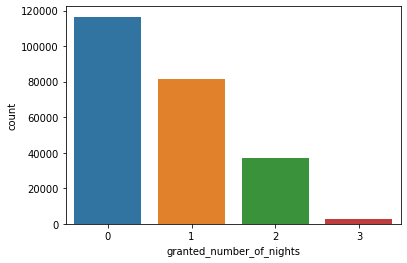

In [119]:
import seaborn as sns
sns.countplot(data_train["granted_number_of_nights"], data=data_train)

there is a significant imbalance, with class 0 clearly dominating the rest of the classes 

## Data cleaning

### Remove null columns >= 95%

#### train data

In [ ]:
null_vals = [None, "None", pd.NaT, float('nan'), "Nat"]
plot_null_rates(data_train, null_vals)

In [126]:
columns_id_to_drop = ["request_id","group_id","group_main_requester_id","request_backoffice_creator_id","social_situation_id"]

In [123]:
null_rates = null_rates(null_matrix(data_train, null_vals))
threshold = 95 #%

In [124]:
columns_to_drop = null_rates.index[np.where(null_rates>=threshold)[0]]
data_train.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped columns {set(columns_to_drop)}")

Dropped columns {'victim_of_violence_type'}


In [127]:
data_train.drop(columns=columns_id_to_drop, inplace=True)
data_train.shape

(238191, 29)

#### test data

In [ ]:
data_test.drop(columns=columns_id_to_drop, inplace=True)
data_test.drop(columns='victim_of_violence_type', inplace=True)
data_test.shape

(59548, 30)

### Remove dulicates

In [141]:
data_train.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
238186    False
238187    False
238188    False
238189    False
238190    False
Length: 238191, dtype: bool

In [142]:
data_test.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
59543    False
59544    False
59545    False
59546    False
59547    False
Length: 59548, dtype: bool

In [143]:
## In case of existing duplicates 
size_before_removing = data_train.shape[0]
data_train = remove_duplicates(data_train)
data_train.reset_index(inplace=True, drop=True)
f'Number of duplicates removed : {size_before_removing - data_train.shape[0]}'

'Number of duplicates removed : 28'

### get numerical cols and categorical cols

In [144]:
requests_train.dtypes

request_id                       object
animal_presence                  object
answer_creation_date             object
child_situation                   int64
child_to_come                    object
district                          int64
granted_number_of_nights          int64
group_composition_id              int64
group_composition_label          object
group_creation_date              object
group_id                         object
group_main_requester_id          object
group_type                       object
housing_situation_id              int64
housing_situation_label          object
long_term_housing_request        object
number_of_underage                int64
request_backoffice_creator_id    object
request_creation_date            object
requester_type                   object
social_situation_id              object
town                             object
victim_of_violence               object
victim_of_violence_type          object
dtype: object

In [145]:
def get_date_columns(df):

    dates = df.select_dtypes(include=[np.datetime64]).columns

    return dates

In [146]:
dates_cols = get_date_columns(data_train) 
dates_cols

Index([], dtype='object')

In [148]:
# convert date cols to datetime type 
dates_col = data_train[["answer_creation_date","group_creation_date","request_creation_date"]]
dates_col_idx = np.array([int(np.where(data_train.columns ==c)[0]) for c in dates_col])
data_train.iloc[:, dates_col_idx] = data_train.iloc[:, dates_col_idx].apply(pd.to_datetime)
data_test.iloc[:, dates_col_idx] = data_test.iloc[:, dates_col_idx].apply(pd.to_datetime)

c:\dev\projects\ai-notebooks\.venv\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [149]:
num_col, cat_col, dates_col = columns_by_type(data_train)

print("NUMERICAL : ", num_col)
print("\n----------\nCATEGORICAL : ", cat_col)
print("\n----------\nDATES : ", dates_col)
print(len(cat_col))

NUMERICAL :  Index(['child_situation', 'district', 'granted_number_of_nights',
       'group_composition_id', 'housing_situation_id', 'number_of_underage',
       'age_mean', 'age_min', 'age_max', 'gender_sum', 'pregnancy_sum',
       'housing_situation_2_id_mean', 'individual_id_count'],
      dtype='object')

----------
CATEGORICAL :  Index(['animal_presence', 'child_to_come', 'group_composition_label',
       'group_type', 'housing_situation_label', 'long_term_housing_request',
       'requester_type', 'town', 'victim_of_violence',
       'housing_situation_2_label_mode', 'individual_role_mode',
       'individual_role_2_label_mode', 'marital_status_label_mode'],
      dtype='object')

----------
DATES :  Index(['answer_creation_date', 'group_creation_date', 'request_creation_date'], dtype='object')
13


#### replace the null values 

In [150]:
# Everything not specified previously is treated here
data_train = fill_na(data_train, numerical_filling=0, categorical_filling="INCONNU", date_filling=pd.NaT)
data_test = fill_na(data_test, numerical_filling=0, categorical_filling="INCONNU", date_filling=pd.NaT)

In [ ]:
# plot the null values ratio after replacing
plot_null_rates(data_train, null_vals)

### Outliers
I've decided that it's not necessary to remove the outliers because in our case, the numerical data contains codes that are a translation of a categorical value, e.g. for the characteristic individual_role_2_id = 30 this means that the person is isolated when the value is 70 this means that the person is a child. 

In [152]:
# drop dates cols and town
data_train.drop(columns=dates_col, inplace= True)
data_test.drop(columns=dates_col, inplace= True)
data_train.drop(columns=["town"], inplace= True)
data_test.drop(columns=["town"], inplace= True)

## Data preprocessing

In [ ]:
y_train = data_train[target]
X_train = data_train.copy()
X_train.drop(columns=target, inplace=True)

In [154]:
y_test =data_test[target]
X_test = data_test.copy()
X_test.drop(columns=target, inplace=True)

In [155]:
print(f"Shape of X_train is :{X_train.shape}")
print(f"Shape of y_train is :{y_train.shape}")
print(f"Shape of X_test is :{X_test.shape}")
print(f"Shape of y_test is :{y_test.shape}")

Shape of X_train is :(238163, 24)
Shape of y_train is :(238163,)
Shape of X_test is :(59548, 24)
Shape of y_test is :(59548,)


In [157]:
num_col, cat_col, dates_cols= columns_by_type(X_train)
cat_col = [col for col in cat_col if col not in ['gender', 'pregnancy', 'victim_of_violence','animal_presence','child_to_come','long_term_housing_request','group_type']]
num_col_idx = np.array([int(np.where(X_train.columns == c)[0]) for c in num_col])
cat_col_idx = np.array([int(np.where(X_train.columns == c)[0]) for c in cat_col])

### Data preprocessing

#### Numerical features Scaling

In [202]:
x_train = X_train.copy()
x_test = X_test.copy()

#### Categorical features embedding

In [203]:

# convert long_term_housing_request column
x_train["long_term_housing_request"] =x_train["long_term_housing_request"].astype(str).str.lower().map({"f":0, "t": 1})
x_test["long_term_housing_request"] = x_test["long_term_housing_request"].astype(str).str.lower().map({"f":0, "t": 1})
x_train["long_term_housing_request"] = x_train["long_term_housing_request"].fillna(-1).astype(int)
x_test["long_term_housing_request"] = x_test["long_term_housing_request"].fillna(-1).astype(int)
x_train["long_term_housing_request"].value_counts()

-1    165550
 0     60367
 1     12246
Name: long_term_housing_request, dtype: int64

In [204]:
# convert child_to_come column
x_train["child_to_come"] =x_train["child_to_come"].astype(str).str.lower().map({"f":0, "t": 1})
x_test["child_to_come"] =x_test["child_to_come"].astype(str).str.lower().map({"f":0, "t": 1})
x_train["child_to_come"] = x_train["child_to_come"].fillna(-1).astype(int)
x_test["child_to_come"] = x_test["child_to_come"].fillna(-1).astype(int)
x_train["child_to_come"].value_counts()


-1    145944
 0     85861
 1      6358
Name: child_to_come, dtype: int64

In [205]:
# convert animal_presence column
x_train["animal_presence"] =x_train["animal_presence"].astype(str).str.lower().map({"f":0, "t": 1})
x_test["animal_presence"] =x_test["animal_presence"].astype(str).str.lower().map({"f":0, "t": 1})
x_train["animal_presence"] = x_train["animal_presence"].fillna(-1).astype(int)
x_test["animal_presence"] = x_test["animal_presence"].fillna(-1).astype(int)
x_train["animal_presence"].value_counts()


0    237500
1       663
Name: animal_presence, dtype: int64

In [206]:
## convert group_type column
x_train["group_type"] = x_train["group_type"].astype(str).str.lower().map({"group": 1, "individual": 0})
x_test["group_type"] = x_test["group_type"].astype(str).str.lower().map({"group": 1, "individual": 0})
x_train["group_type"] = x_train["group_type"].fillna(-1).astype(int)
x_test["group_type"] = x_test["group_type"].fillna(-1).astype(int)
x_train["group_type"].value_counts()

0    171038
1     67125
Name: group_type, dtype: int64

In [207]:
# convert victim_of_violence column
x_train["victim_of_violence"] =x_train["victim_of_violence"].astype(str).str.lower().map({"f":0, "t": 1})
x_test["victim_of_violence"] =x_test["victim_of_violence"].astype(str).str.lower().map({"f":0, "t": 1})
x_train["victim_of_violence"] = x_train["victim_of_violence"].fillna(-1).astype(int)
x_test["victim_of_violence"] = x_test["victim_of_violence"].fillna(-1).astype(int)
x_train["victim_of_violence"].value_counts()


0    233853
1      4310
Name: victim_of_violence, dtype: int64

#### Apply onehot_encoding

In [208]:
print(f"Valuers unique par colonnes :\n {x_train[cat_col].nunique()}")

Valuers unique par colonnes :
 group_composition_label           12
housing_situation_label           22
requester_type                     3
housing_situation_2_label_mode    28
individual_role_mode               8
individual_role_2_label_mode       9
marital_status_label_mode          9
dtype: int64


In [209]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_train_encoded_cat = encoder.fit_transform(x_train[cat_col])
X_test_encoded_cat = encoder.fit_transform(x_test[cat_col])

In [210]:
print(f"Shape après encodage - X_train_encoded_cat: {X_train_encoded_cat.shape}")
print(f"Shape après encodage - X_test_encoded_cat: {X_test_encoded_cat.shape}")

Shape après encodage - X_train_encoded_cat: (238163, 91)
Shape après encodage - X_test_encoded_cat: (59548, 91)


In [ ]:
X_train_encoded_cat = pd.DataFrame(X_train_encoded_cat, columns= encoder.get_feature_names(cat_col))
X_test_encoded_cat = pd.DataFrame(X_test_encoded_cat, columns= encoder.get_feature_names(cat_col))
# Remettre les index alignés
X_train_encoded_cat.index = x_train.index
X_test_encoded_cat.index = x_test.index

# Supprimer les anciennes colonnes et ajouter les nouvelles encodées
X_train_new = x_train.drop(columns=cat_col).reset_index(drop=True)
X_test_new = x_test.drop(columns=cat_col).reset_index(drop=True)

X_train_= pd.concat([X_train_new, X_train_encoded_cat], axis=1).astype(int)
X_test_ = pd.concat([X_test_new, X_test_encoded_cat], axis=1).astype(int)


In [219]:
scaler = StandardScaler()
scaler.fit(X_train_)
X_train_scaled = scaler.transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

In [220]:
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train_.columns,
    index=X_train_.index
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=X_test_.columns,
    index=X_test_.index
)

In [221]:
print(f"Shape of X_train is :{X_train_scaled.shape}")
print(f"Shape of y_train is :{y_train.shape}")
print(f"Shape of X_test is :{X_test_scaled.shape}")
print(f"Shape of y_test is :{y_test.shape}")

Shape of X_train is :(238163, 108)
Shape of y_train is :(238163,)
Shape of X_test is :(59548, 108)
Shape of y_test is :(59548,)


In [222]:
# export data
X_train_scaled.to_csv("data/cleaned_data/X_train.csv", index=False, encoding='utf-8')
X_test_scaled.to_csv("data/cleaned_data/X_test.csv", index=False, encoding='utf-8')
y_train.to_csv("data/cleaned_data/y_train.csv", index=False, encoding='utf-8')
y_test.to_csv("data/cleaned_data/y_test.csv", index=False, encoding='utf-8')